In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import PDB

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [28]:
def calculate_residue_plddt(json_path, cif_path):
    # Load the JSON data
    with open(json_path) as json_data:
        plddts = json.load(json_data)['atom_plddts']

    # Parse the CIF file
    structure = PDB.MMCIFParser(QUIET=True).get_structure('model', cif_path)

    # Extract atom-to-residue information 
    atom_to_residue = [(chain.id, residue.resname, residue.id[1]) for model in structure for chain in model for residue in chain for atom in residue]

    # Create dataframe
    df = pd.DataFrame({
        'chain_id': [item[0] for item in atom_to_residue],
        'res_name': [item[1] for item in atom_to_residue],
        'res_ids': [item[2] for item in atom_to_residue],
        'plddts': plddts
    })

    # Calculate the mean pLDDT for each residue
    residue_plddt = df.groupby(['chain_id', 'res_ids']).agg(
        res_name = ('res_name', 'first'),
        mean_plddt = ('plddts', 'mean'),
        std_plddt = ('plddts', 'std'),
    ).reset_index()

    residue_plddt['cv_plddt'] = residue_plddt['std_plddt'] / residue_plddt['mean_plddt']

    plt.figure(figsize=(10, 6))
    plt.hist(residue_plddt['mean_plddt'], bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Mean pLDDT')
    plt.ylabel('Frequency')
    plt.title('Histogram of Mean pLDDT for Each Residue')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(15, 6))
    plt.boxplot(residue_plddt['cv_plddt'], vert=True, patch_artist=True)
    plt.xticks([1], ['CV of pLDDT'])
    plt.ylabel('Coefficient of Variation (CV) of pLDDT')
    plt.title('Box Plot of CV of pLDDT for Each Residue')
    plt.grid(True)
    plt.show()

    
    return residue_plddt

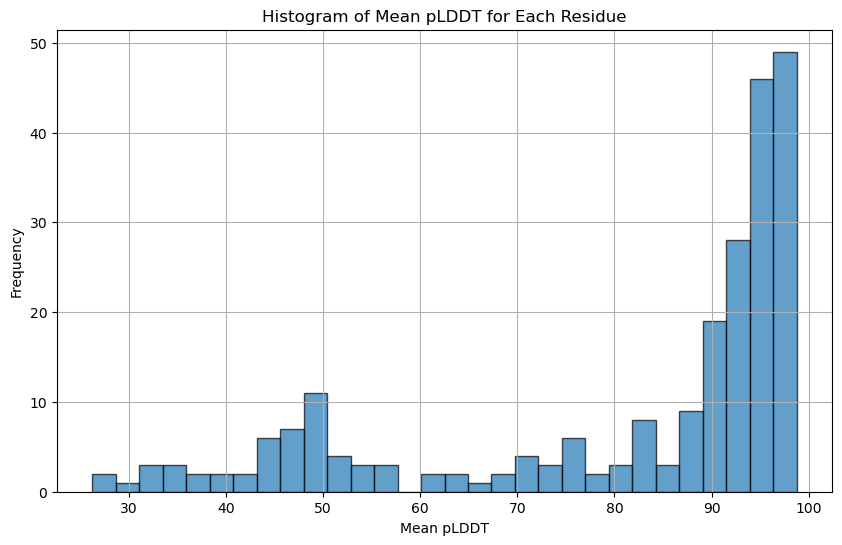

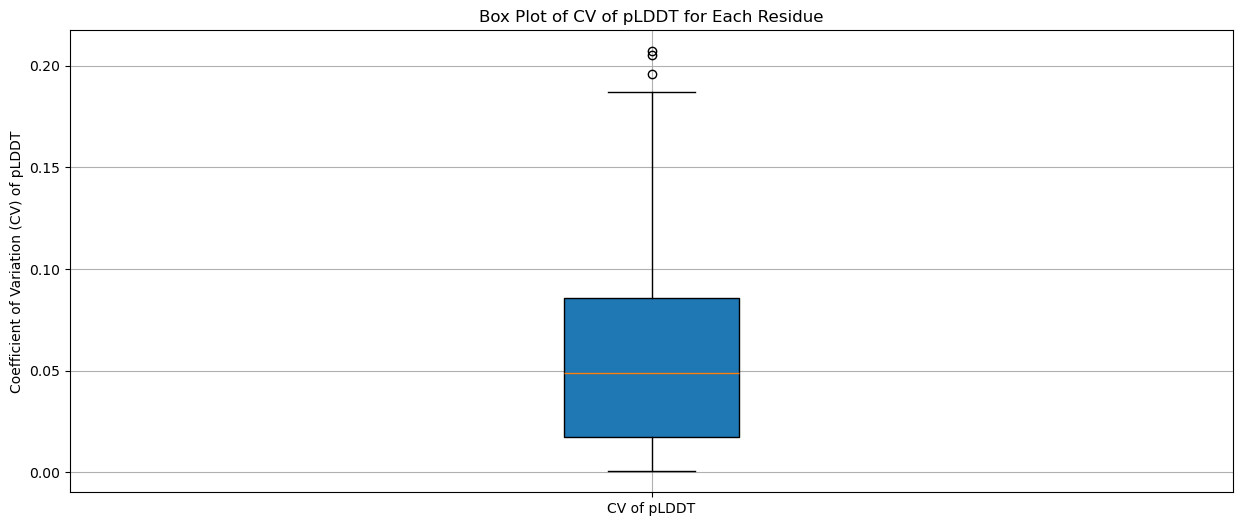

,chain_id,res_ids,res_name,mean_plddt,std_plddt,cv_plddt
0,A,1,MET,32.923750,6.822207,0.207212
1,A,2,SER,33.043333,1.941285,0.058750
2,A,3,ARG,28.700909,5.892986,0.205324
3,A,4,ILE,33.417500,2.666489,0.079793
4,A,5,ILE,26.227500,1.583475,0.060375
...,...,...,...,...,...,...
231,B,110,HIS,76.075000,9.674435,0.127170
232,B,111,ASN,75.127500,6.901577,0.091865
233,B,112,GLU,68.702222,9.241083,0.134509
234,B,113,SER,70.651667,5.500478,0.077853


In [29]:
json_path = "af3_predictions/fold_t1106/fold_t1106_full_data_0.json"
cif_path = "af3_predictions/fold_t1106/fold_t1106_model_0.cif"
display(calculate_residue_plddt(json_path, cif_path))